In [1]:
import sys
sys.path.append(r"C:\Users\shailaja.akella\Dropbox (Personal)\variability_phase4\state_dependent_variability_paper\figure_codes")


import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from scipy import signal
from scipy.ndimage import gaussian_filter

import data_utils as du
import behavior_utils as bu
import lfp_utils as lu


In [2]:
session_id = 767871931
probes = ['probeC', 'probeD', 'probeF', 'probeE', 'probeB', 'probeA']
stim = 'natural_movie_one_more_repeats'
Fs = 30
Fs_lfp = 1250

session = du.get_nwb_session(session_id)
trials = du.trials_table(session, stim)
duration = int(trials.duration.mean())
n_tr = len(trials)

In [3]:
# LFPs
lfp, channel_ids = lu.lfps(session_id, stim)

# running, pupil
pupil_data = bu.pupil_area(session, stim, trials)
running_data = bu.running(session, stim, trials)
binned_running_speed = bu.bin_behavior(running_data, Fs, duration).reshape(-1)
binned_pupil_size = bu.bin_behavior(pupil_data, Fs, duration).reshape(-1)

# STFT
Zxx = np.zeros((lfp['probeC'].shape[0], 1025, 2199)) + np.nan
for ch in range(lfp['probeC'].shape[0]):
    f, t, Zxx[ch] = np.abs(np.array(signal.stft(lfp['probeC'][ch].reshape(-1), Fs_lfp, nperseg=2048), dtype=object))

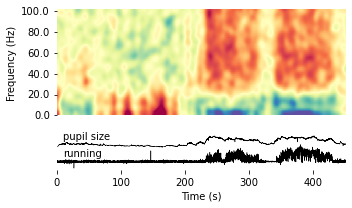

In [4]:
# PLOT
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), gridspec_kw={'height_ratios': [0.75, 0.25]})
x = np.log10(Zxx[0, :, :])
x = np.array([(x_i - np.nanmean(x_i)) / np.std(x_i) for x_i in x])
x = gaussian_filter(x, sigma=5)
idx = np.argmin(np.abs(f - 100))
sns.heatmap(np.flipud(x[:idx, 700:1250]), cmap='Spectral_r', center=0, vmax=0.7, ax=ax[0],
            vmin=-0.7, xticklabels=100, cbar=False)
ax[0].set_yticks(idx - np.arange(0, 170, 32), labels=np.round(f[np.arange(0, 170, 32)] / 10) * 10, rotation=0);
ax[0].set_xticks([])
ax[0].set_ylabel('Frequency (Hz)')

Hz = 30
t_start = int(t[700] * Hz)
t_end = int(t[1250] * Hz)
ax[1].plot(np.arange(t_end - t_start) / Hz, binned_pupil_size[t_start:t_end] + 7, color='k', lw=0.5)
ax[1].text(10, 9, 'pupil size')
ax[1].plot(np.arange(t_end - t_start) / Hz, binned_running_speed[t_start:t_end], color='k', lw=0.5)
ax[1].text(10, 2, 'running')
plt.yticks([])
ax[1].set_xlim(0, len(binned_pupil_size[t_start:t_end]) / Hz)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xlabel('Time (s)')
plt.tight_layout()